# A Three tank example

This is a slightly larger example on residual generator design/simulation for the Three-tank example from the paper 

"_Diagnosability Analysis Considering Causal Interpretations for Differential Constraints_", Erik Frisk, Anibal Bregon, Jan Aaslund, Mattias Krysander, Belarmino Pulido, and Gautam Biswas IEEE Transactions on Systems, Man and Cybernetics, Part A: Systems and Humans (2012), Vol. 42, No. 5, 1216-1229.

<center><img src="../images/Three_tanks.png" alt="drawing" width="50%"/></center>

This example will go through the process of 
* defining a model
* initial model analysis
* residual generator analysis
* generating C-code for a few residual generators
* simulating the process and generating synthetic data
* running the residual generators on the generated data

First, the necessary imports

In [35]:
import faultdiagnosistoolbox as fdt
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_continuous_are
import seaborn as sns
import os
import TankSimulation

## Defining the model
The model is a simple, linear, model in 12 equations, with threee measurements, and 6 faults as below

<center><img src="../images/tt_equations.png" alt="equations" width="50%"/></center>

Using the symbolic toolbox `sympy`, the model can be defined by

In [36]:
modelDef = {}
modelDef['type'] = 'Symbolic'
modelDef['x'] = ['p1', 'p2', 'p3', 'q0', 'q1', 'q2', 'q3', 'dp1', 'dp2', 'dp3']
modelDef['f'] = ['fV1', 'fV2', 'fV3', 'fT1', 'fT2', 'fT3']
modelDef['z'] = ['y1', 'y2', 'y3']
modelDef['parameters'] = ['Rv1', 'Rv2', 'Rv3', 'CT1', 'CT2', 'CT3']

p1, p2, p3, q0, q1, q2, q3, dp1, dp2, dp3 = sym.symbols(modelDef['x'])
fV1, fV2, fV3, fT1, fT2, fT3 = sym.symbols(modelDef['f'])
y1, y2, y3 = sym.symbols(modelDef['z'])
Rv1, Rv2, Rv3, CT1, CT2, CT3 = sym.symbols(modelDef['parameters'])

modelDef['rels'] = [
    -q1 + 1 / Rv1 * (p1 - p2) + fV1,
    -q2 + 1 / Rv2 * (p2 - p3) + fV2,
    -q3 + 1 / Rv3 * p3 + fV3,
    -dp1 + 1 / CT1 * (q0 - q1) + fT1,
    -dp2 + 1 / CT2 * (q1 - q2) + fT2,
    -dp3 + 1 / CT3 * (q2 - q3) + fT3,
    -y1 + p1, -y2 + q2, -y3 + q0,
    fdt.DiffConstraint('dp1', 'p1'),
    fdt.DiffConstraint('dp2', 'p2'),
    fdt.DiffConstraint('dp3', 'p3')]

model = fdt.DiagnosisModel(modelDef, name='Three Tank System')
model_params = {'Rv1': 1, 'Rv2': 1, 'Rv3': 1, 'CT1': 1, 'CT2': 1, 'CT3': 1}

model.Lint()

Model: Three Tank System

  Type:Symbolic, dynamic

  Variables and equations
    10 unknown variables
    3 known variables
    6 fault variables
    12 equations, including 3 differential constraints

  Degree of redundancy: 2
  Degree of redundancy of MTES set: 1


  Model validation finished with 0 errors and 0 warnings.


The model structure can be visualized as

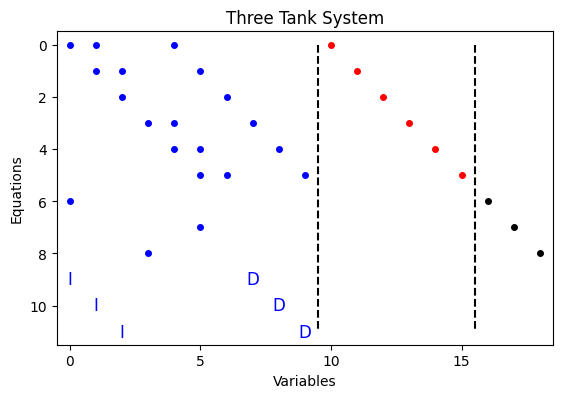

In [37]:
_, ax = plt.subplots(num=10, clear=True)
model.PlotModel()

## Initial model analysis

A basic Dulmage-Mendelsohn decoposition illustrates isolability properties of the model

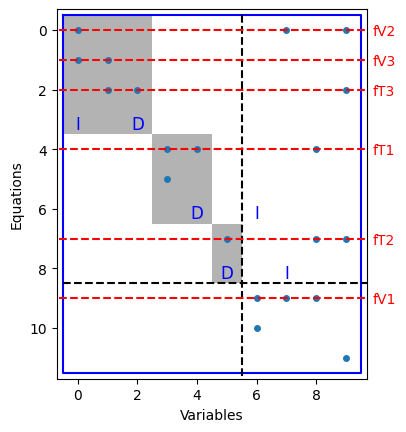

In [38]:
_, ax = plt.subplots(num=23, clear=True)
model.PlotDM(ax=ax, fault=True, eqclass=True)

A more detailed isolability analysis, considering different causality assumptions can be done using the `IsolabilityAnalysis` class method

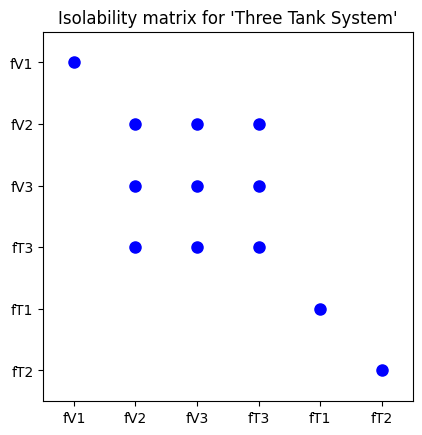

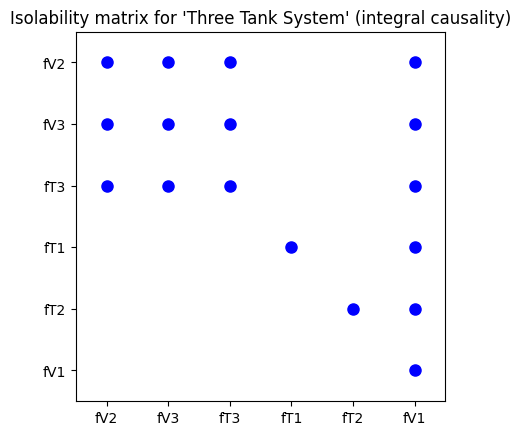

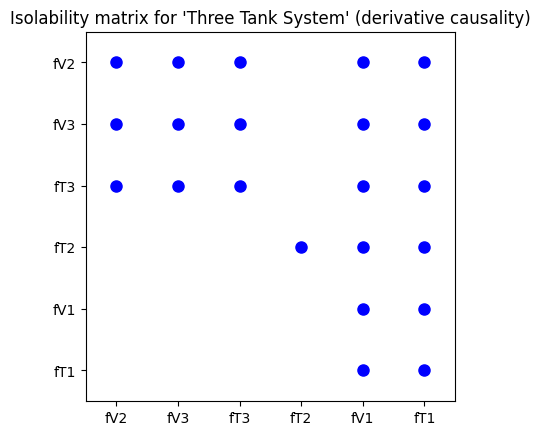

In [39]:
_, ax = plt.subplots(num=20, clear=True)
model.IsolabilityAnalysis(ax=ax)

_, ax = plt.subplots(num=21, clear=True)
model.IsolabilityAnalysis(ax=ax, causality='int')

_, ax = plt.subplots(num=22, clear=True)
_ = model.IsolabilityAnalysis(ax=ax, causality='der')

## Residual generator analysis

First, compute the set of MSO and MTES sets

In [40]:
msos = model.MSO()
mtes = model.MTES()
print(f"Found {len(msos)} MSO sets")
print(f"Found {len(mtes)} MTES sets")

Found 6 MSO sets
Found 4 MTES sets


Look at differential-index properties of the MSO and MTES sets

In [41]:
li_msos = [m for m in msos if model.IsLowIndex(m)]
li_mtes = [m for m in mtes if model.IsLowIndex(m)]
print(f"{len(li_msos)} of the MSO sets are low index")
print(f"{len(li_mtes)} of the MTES sets are low index")


5 of the MSO sets are low index
3 of the MTES sets are low index


Take two MSO sets with different index properties and see how to choose redundant equations

In [42]:
mso1 = msos[0]
mso2 = msos[1]
print(model.MSOCausalitySweep(mso1))
print(model.MSOCausalitySweep(mso2))

['mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed', 'mixed']
['der', 'int', 'der', 'mixed', 'mixed', 'mixed', 'int', 'mixed']


Here it is clear that in `mso1`, no choice of residual equation gives integral causality in the residual generator. However, for `mso2`, two equations are possible!

## Residual generator design and code generation

Now, three residual generators will be designed corresponding to figures 2, 3, and 12 in the paper. 

### Residuals, code generation
Residual 1 is based on the second MSO set, using equation e5 as a redundant equation, which will result in a sequential residual generator in derivative causality. The computational graph, Fig. 2 in the paper, is given by:

<center><img src="../images/tt_r1.png" alt="residual 1" width="75%"/></center>

In [43]:
eqr1 = mso2
redeq1 = 4
m01 = [e for e in eqr1 if e != redeq1]
Gamma1 = model.Matching(m01)
model.SeqResGen(Gamma1, redeq1, 'ResGen1', batch=True, language='C')
print("")

Generating residual generator ResGen1 (C, batch)
  Generating code for the exactly determined part: .......
  Generating code for the residual equations
  Writing residual generator file
Files ResGen1.cc and ResGen1_setup.py generated
Compile by running: python ResGen1_setup.py build_ext --inplace



Residual 2 is based on the same second MSO set but using equation e7 as a redundant equation, which will result in a sequential residual generator in integral causality. The computational graph, Fig. 3 in the paper, is given by:

<center><img src="../images/tt_r2.png" alt="residual 2" width="75%"/></center>

In [44]:
eqr2 = mso2
redeq2 = 6
m02 = [e for e in eqr2 if e != redeq2]
Gamma2 = model.Matching(m02)
model.SeqResGen(Gamma2, redeq2, 'ResGen2', batch=True, language='C')
print("")

Generating residual generator ResGen2 (C, batch)
  Generating code for the exactly determined part: ...
  Generating code for the residual equations
  Writing residual generator file
Files ResGen2.cc and ResGen2_setup.py generated
Compile by running: python ResGen2_setup.py build_ext --inplace



Residual 3 is based on the first MSO set using equation e2 as a redundant equation, which will result in a sequential residual generator in mixed causality. The computational graph, Fig. 12 in the paper, is given by:

<center><img src="../images/tt_r3.png" alt="residual 2" width="75%"/></center>

In [45]:
eqr3 = mso1
redeq3 = 1
m03 = [e for e in eqr3 if e != redeq3]
Gamma3 = model.Matching(m03)
model.SeqResGen(Gamma3, redeq3, 'ResGen3', batch=True, language='C')
print("")

Generating residual generator ResGen3 (C, batch)
  Generating code for the exactly determined part: ........
  Generating code for the residual equations
  Writing residual generator file
Files ResGen3.cc and ResGen3_setup.py generated
Compile by running: python ResGen3_setup.py build_ext --inplace



### Residuals, compile generated code
Now that the code is generated, compile and import the generated c-extension modules.

In [46]:
for resName in ['ResGen1', 'ResGen2', 'ResGen3']:
    print(f"Compiling residual generator: {resName} ... ", end='')
    compile_cmd = f"python {resName}_setup.py build_ext --inplace > /dev/null"
    if os.system(compile_cmd) == 0:
        print('Success!')
    else:
        print('Failure!')

Compiling residual generator: ResGen1 ... Success!
Compiling residual generator: ResGen2 ... Success!
Compiling residual generator: ResGen3 ... Success!


and import

In [47]:
import ResGen1
import ResGen2
import ResGen3
print("All residual generators imported/reloaded")

All residual generators imported/reloaded


### Diagnosis properties of the three generated residuals
Generate the fault signature matrix (FSM) and isolability properties of the three generated residual generators.

Text(0.5, 1.0, 'Isolability matrix')

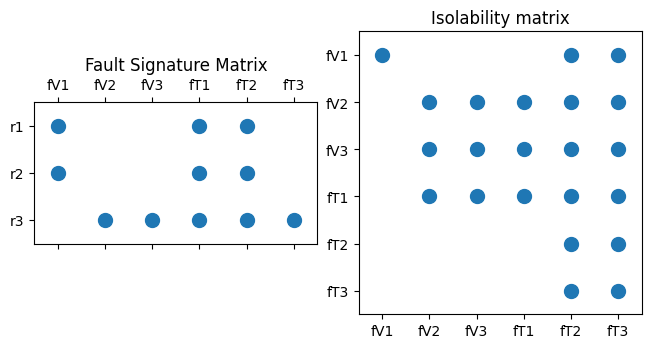

In [48]:
_, ax = plt.subplots(1, 2, num=50, clear=True, layout="constrained")
FSM = model.FSM([mso2, mso2, mso1])
ax[0].spy(FSM, markersize=10, marker="o")
ax[0].set_yticks(range(3))
ax[0].set_yticklabels([f"r{k + 1}" for k in range(3)])
ax[0].set_xticks(range(6))
ax[0].set_xticklabels(model.f)
ax[0].set_title('Fault Signature Matrix')

model.IsolabilityAnalysisFSM(FSM, ax=ax[1])
ax[1].set_title('Isolability matrix')

## Simulate

Next step is to simulate the process with all faults. For this, we need a controller. Here, a simple LQR-controller is designed to follow a reference pressure in the first tank.

In [49]:
G = TankSimulation.ThreeTank_ss(model_params)  # Get state-space matrices

Q = np.eye(3)
R = np.eye(1) * 0.5
P = solve_continuous_are(G['A'], G['B'], Q, R)
Lx = np.linalg.solve(R, G['B'].T @ P)
Lr = -1 / (np.array([1, 0, 0]) @ np.linalg.inv(G['A'] - G['B'] @ Lx) @ G['B'])

Define the reference signal and the controller function

In [50]:
def ref(t):
    return 0.2 * np.sin(2 * np.pi * 1 / 10 * t) + 1


def controller(t, x):
    return (-Lx @ x + Lr * ref(t))[0]

Now, simulate the fault-free behavior and all 6 fault modes. For each fault mode, a ramp-function is used as the fault signal.

In [51]:
t = np.linspace(0, 20, 201)
x0 = [0, 0, 0]
sim = ({'NF': TankSimulation.SimScenario(0, lambda t: 0 * t, controller, model_params, t, x0)} |
       {fi: TankSimulation.SimScenario(k + 1, lambda t: 0.3 * TankSimulation.ramp(t, 6, 10), controller, model_params, t, x0) for k, fi in enumerate(model.f)})

Plot some data from the fault-free and the fV1 scenarios

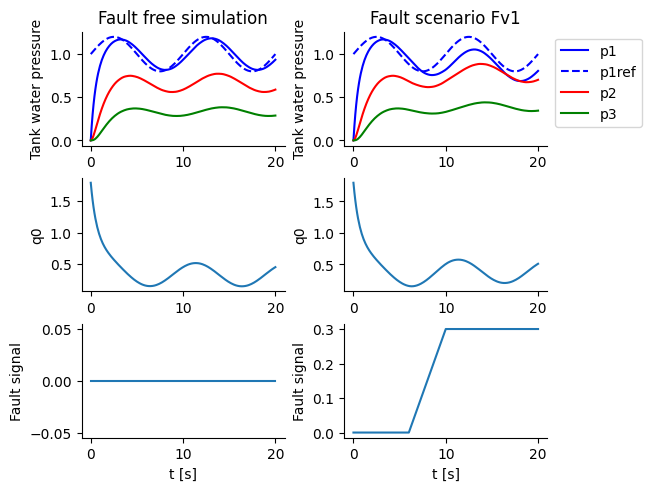

In [52]:
_, ax = plt.subplots(3, 2, num=40, clear=True, layout="constrained")
ax[0, 0].plot(sim['NF'].t, sim['NF'].w[0], 'b', label='p1')
ax[0, 0].plot(sim['NF'].t, ref(sim['NF'].t), 'b--', label='p1ref')
ax[0, 0].plot(sim['NF'].t, sim['NF'].w[1], 'r', label='p2')
ax[0, 0].plot(sim['NF'].t, sim['NF'].w[2], 'g', label='p3')
ax[0, 0].set_ylabel('Tank water pressure')
ax[0, 0].set_title('Fault free simulation')
sns.despine(ax=ax[0, 0])

ax[1, 0].plot(sim['NF'].t, sim['NF'].w[3])
ax[1, 0].set_ylabel('q0')
sns.despine(ax=ax[1, 0])

ax[2, 0].plot(sim['NF'].t, sim['NF'].f)
ax[2, 0].set_ylabel('Fault signal')
ax[2, 0].set_xlabel('t [s]')
sns.despine(ax=ax[2, 0])

ax[0, 1].plot(sim['fV1'].t, sim['fV1'].w[0], 'b', label='p1')
ax[0, 1].plot(sim['fV1'].t, ref(sim['fV1'].t), 'b--', label='p1ref')
ax[0, 1].plot(sim['fV1'].t, sim['fV1'].w[1], 'r', label='p2')
ax[0, 1].plot(sim['fV1'].t, sim['fV1'].w[2], 'g', label='p3')
ax[0, 1].set_ylabel('Tank water pressure')
ax[0, 1].legend(loc='upper right', bbox_to_anchor=(1.5, 1.0))
ax[0, 1].set_title('Fault scenario Fv1')
sns.despine(ax=ax[0, 1])

ax[1, 1].plot(sim['fV1'].t, sim['fV1'].w[3])
ax[1, 1].set_ylabel('q0')
sns.despine(ax=ax[1, 1])

ax[2, 1].plot(sim['fV1'].t, sim['fV1'].f)
ax[2, 1].set_ylabel('Fault signal')
ax[2, 1].set_xlabel('t [s]')
sns.despine(ax=ax[2, 1])


## Run residual generators on simulated data

Run the three residual generators on all generated data

In [53]:
res = {}
for fault_mode in ['NF'] + model.f:
    Ts = sim[fault_mode].t[1] - sim[fault_mode].t[0]

    state1 = {'p1': sim[fault_mode].w[0, 0], 'p2': sim[fault_mode].w[1, 0]}
    state2 = {'p1': sim[fault_mode].w[0, 0], 'p2': sim[fault_mode].w[1, 0]}
    state3 = {'p1': sim[fault_mode].w[0, 0], 'p2': sim[fault_mode].w[1, 0], 'p3': sim[fault_mode].w[2, 0]}
    
    r1 = ResGen1.ResGen1(sim[fault_mode].z, state1, model_params, Ts)
    r2 = ResGen2.ResGen2(sim[fault_mode].z, state2, model_params, Ts)
    r3 = ResGen3.ResGen3(sim[fault_mode].z, state3, model_params, Ts)
    r1[0:2] = 0.0
    r3[0] = 0.0
    res[fault_mode] = np.row_stack((r1, r2, r3))

and plot some results

Text(0.5, 1.0, 'r3 (seq/mixed/discrete)')

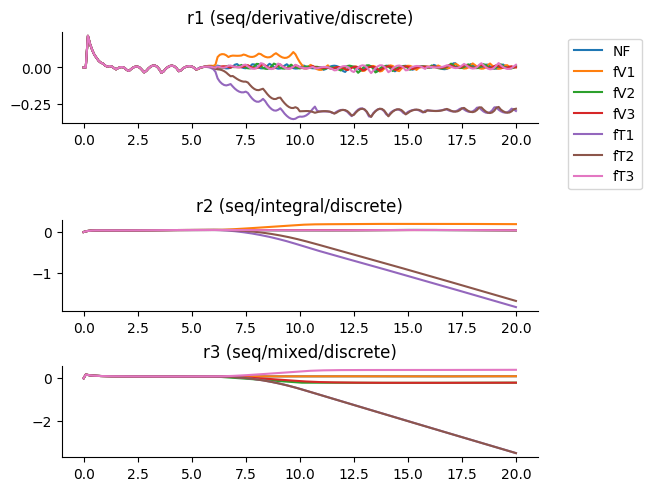

In [54]:
# Plot some results
fig, ax = plt.subplots(3, 1, num=60, clear=True, layout="constrained")
for fault_mode in res:    
    ax[0].plot(sim[fault_mode].t, res[fault_mode][0], label=fault_mode)
    ax[1].plot(sim[fault_mode].t, res[fault_mode][1])
    ax[2].plot(sim[fault_mode].t, res[fault_mode][2])
sns.despine(ax=ax[0])
ax[0].legend(bbox_to_anchor=(1.05, 1))
ax[0].set_title('r1 (seq/derivative/discrete)')
sns.despine(ax=ax[1])
ax[1].set_title('r2 (seq/integral/discrete)')
sns.despine(ax=ax[2])
ax[2].set_title('r3 (seq/mixed/discrete)')

Here it is clear that the residual with numerical differentiation is unreliable and requres additional filtering.